In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/1000-most-trending-youtube-videos/top-1000-trending-youtube-videos.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## 1. Preprocessing

In [3]:
# Load data
df = pd.read_csv('/kaggle/input/1000-most-trending-youtube-videos/top-1000-trending-youtube-videos.csv')
df.head()

,rank,Video,Video views,Likes,Dislikes,Category,published
0,1,"20 Tennis shots if they were not filmed, NOBOD...","3,471,237","19,023",859,NaN,2017
1,2,Lil Nas X - Old Town Road (Official Movie) ft....,"54,071,677","3,497,955","78,799",Music,2019
2,3,JoJo Siwa - Karma (Official Video),"34,206,747","293,563",NaN,Music,2024
3,4,Wiz Khalifa - See You Again ft. Charlie Puth [...,"6,643,904,918","44,861,602",NaN,Music,2015
4,5,伊賀の天然水強炭酸水「家族で、シュワシェア。」篇 15秒,"236,085,971",38,NaN,NaN,2021


In [4]:
# View number of rows and columns
df.shape

(1000, 7)

In [5]:
# Check basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rank         1000 non-null   int64 
 1   Video        1000 non-null   object
 2   Video views  1000 non-null   object
 3   Likes        973 non-null    object
 4   Dislikes     687 non-null    object
 5   Category     820 non-null    object
 6   published    1000 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 54.8+ KB


In [6]:
# Confirm null entries
df.isnull().sum()

rank             0
Video            0
Video views      0
Likes           27
Dislikes       313
Category       180
published        0
dtype: int64

In [7]:
# Duplicates
df.duplicated().sum()

0

In [8]:
# Summary statistics of numerical values
df.describe()

,rank,published
count,1000.000000,1000.000000
mean,500.500000,2015.933000
std,288.819436,6.054847
min,1.000000,2005.000000
25%,250.750000,2010.000000
50%,500.500000,2017.000000
75%,750.250000,2021.000000
max,1000.000000,2025.000000


In [9]:
# Step 1: Inspect data types and sample values
print("Initial Data Types:")
print(df.dtypes)
print("\nSample Data (First 5 Rows):")
print(df.head())

Initial Data Types:
rank            int64
Video          object
Video views    object
Likes          object
Dislikes       object
Category       object
published       int64
dtype: object

Sample Data (First 5 Rows):
   rank                                              Video    Video views  \
0     1  20 Tennis shots if they were not filmed, NOBOD...      3,471,237   
1     2  Lil Nas X - Old Town Road (Official Movie) ft....     54,071,677   
2     3                 JoJo Siwa - Karma (Official Video)     34,206,747   
3     4  Wiz Khalifa - See You Again ft. Charlie Puth [...  6,643,904,918   
4     5                       伊賀の天然水強炭酸水「家族で、シュワシェア。」篇　15秒    236,085,971   

        Likes Dislikes Category  published  
0      19,023      859      NaN       2017  
1   3,497,955   78,799    Music       2019  
2     293,563      NaN    Music       2024  
3  44,861,602      NaN    Music       2015  
4          38      NaN      NaN       2021  


In [10]:
# Step 2: Convert object columns to numeric, handling commas only if necessary
for col in ['Video views', 'Likes', 'Dislikes']:
    if df[col].dtype == 'object':
        print(f"Converting {col} from object to numeric...")
        df[col] = df[col].str.replace(',', '').astype(float)
    else:
        print(f"{col} is already numeric (type: {df[col].dtype}), skipping string conversion.")

Converting Video views from object to numeric...
Converting Likes from object to numeric...
Converting Dislikes from object to numeric...


In [11]:
# Step 3: Handle missing values
# Impute Likes and Dislikes with median (robust to outliers)
df['Likes'] = df['Likes'].fillna(df['Likes'].median())
df['Dislikes'] = df['Dislikes'].fillna(df['Dislikes'].median())

# Impute Category with mode (most frequent category)
df['Category'] = df['Category'].fillna(df['Category'].mode()[0])

In [12]:
# Step 4: Drop 'Video' column (title not used for prediction)
df = df.drop(columns=['Video'])

In [13]:
# Step 5: Verify data types, missing values, and dataset summary
print("\nCleaned Data Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDataset Shape:", df.shape)
print("\nFirst 5 Rows of Cleaned Data:")
print(df.head())


Cleaned Data Types:
rank             int64
Video views    float64
Likes          float64
Dislikes       float64
Category        object
published        int64
dtype: object

Missing Values:
rank           0
Video views    0
Likes          0
Dislikes       0
Category       0
published      0
dtype: int64

Dataset Shape: (1000, 6)

First 5 Rows of Cleaned Data:
   rank   Video views       Likes  Dislikes Category  published
0     1  3.471237e+06     19023.0     859.0    Music       2017
1     2  5.407168e+07   3497955.0   78799.0    Music       2019
2     3  3.420675e+07    293563.0     257.0    Music       2024
3     4  6.643905e+09  44861602.0     257.0    Music       2015
4     5  2.360860e+08        38.0     257.0    Music       2021


**Just a Couple Potential Concerns:**
- **Imputation Impact:** Imputing 313 Dislikes and 180 Category values with the median and mode, respectively, may introduce bias, especially if "Music" dominates due to mode imputation. We’ll verify this in EDA by checking category distribution.
- **Skewness:** The large range in Video views and Likes (e.g., 38 likes vs. 44M likes) indicates right-skewed distributions, necessitating log transformation or robust scaling in modeling.

## 2. Exploratory Data Analysis

In [14]:
# Set plot style
plt.style.use('seaborn')
sns.set(font_scale=1.2)

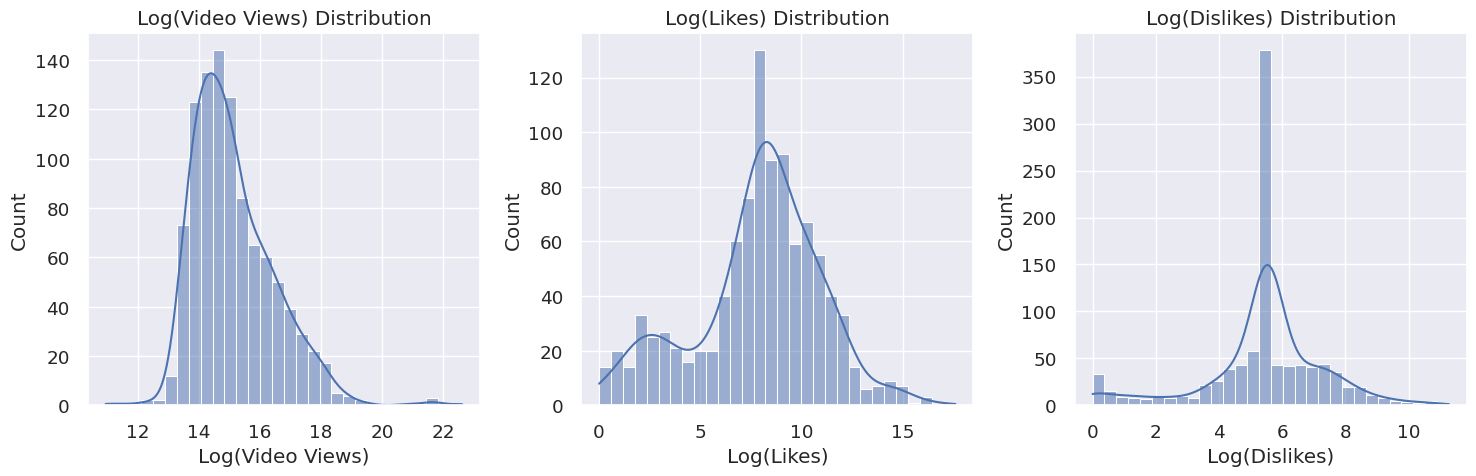

In [15]:
# 1. Distribution of Video views, Likes, and Dislikes (log scale due to skewness)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(np.log1p(df['Video views']), bins=30, kde=True)
plt.title('Log(Video Views) Distribution')
plt.xlabel('Log(Video Views)')

plt.subplot(1, 3, 2)
sns.histplot(np.log1p(df['Likes']), bins=30, kde=True)
plt.title('Log(Likes) Distribution')
plt.xlabel('Log(Likes)')

plt.subplot(1, 3, 3)
sns.histplot(np.log1p(df['Dislikes']), bins=30, kde=True)
plt.title('Log(Dislikes) Distribution')
plt.xlabel('Log(Dislikes)')

plt.tight_layout()
plt.show()

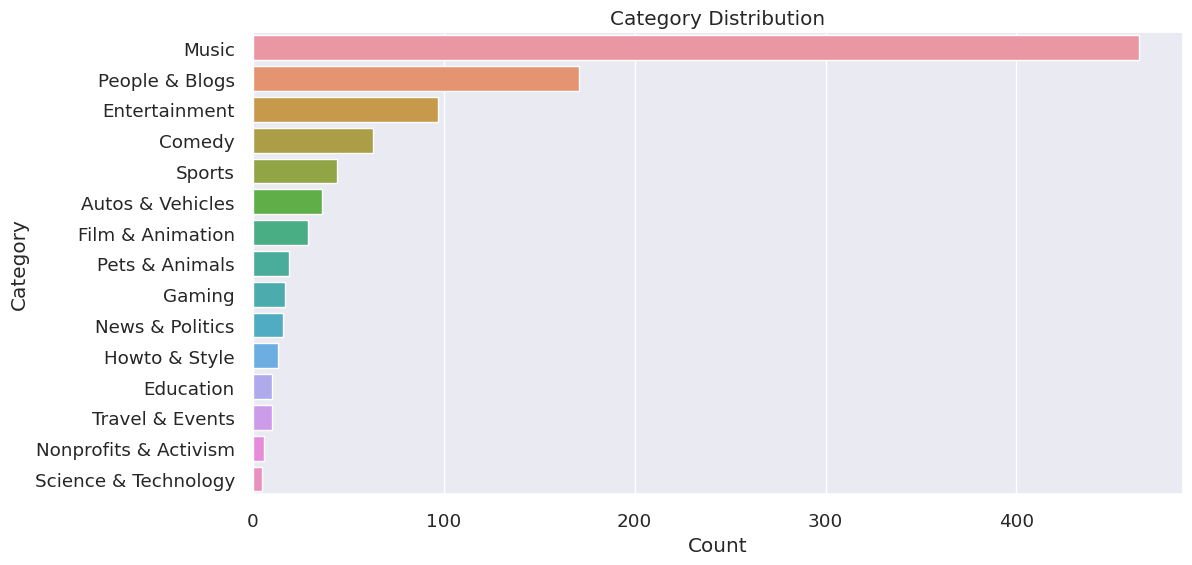

In [16]:
# 2. Category distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index)
plt.title('Category Distribution')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

Text(0, 0.5, 'Log(Video Views)')

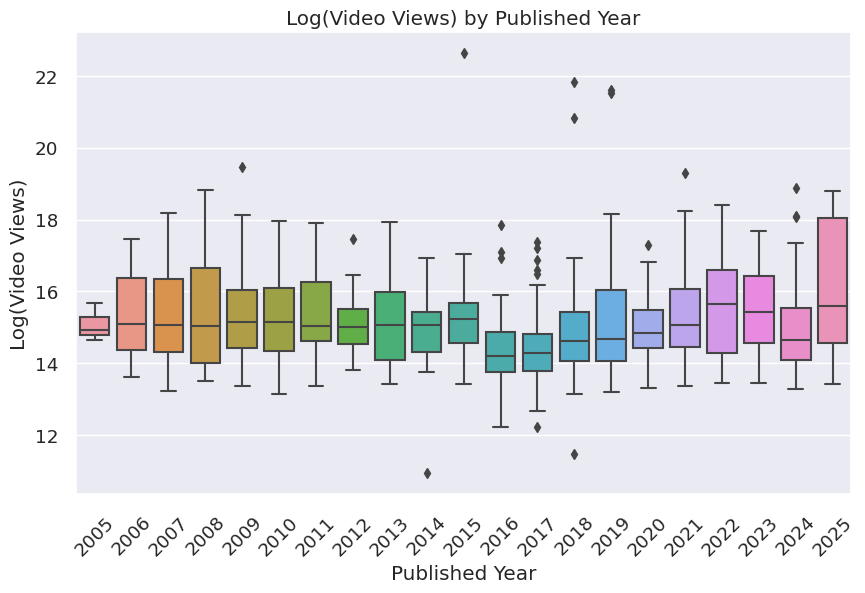

In [17]:
# 3. Video views by Published Year
plt.figure(figsize=(10, 6))
sns.boxplot(x='published', y=np.log1p(df['Video views']), data=df)
plt.title('Log(Video Views) by Published Year')
plt.xticks(rotation=45)
plt.xlabel('Published Year')
plt.ylabel('Log(Video Views)')

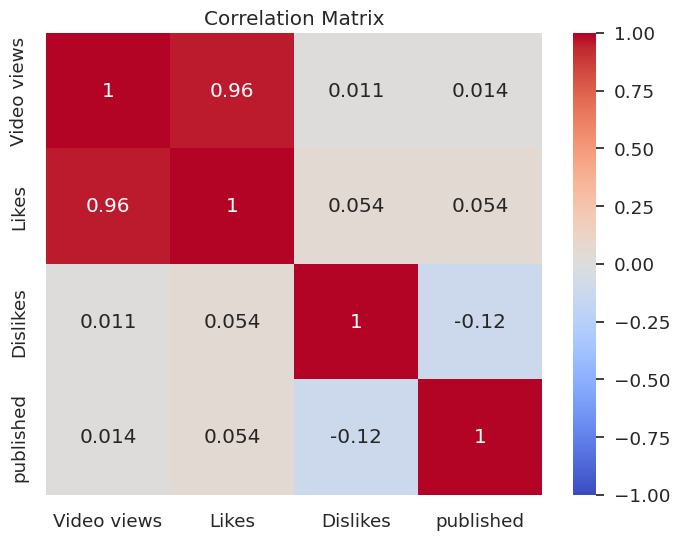

In [18]:
# 4. Correlation matrix
plt.figure(figsize=(8, 6))
corr = df[['Video views', 'Likes', 'Dislikes', 'published']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

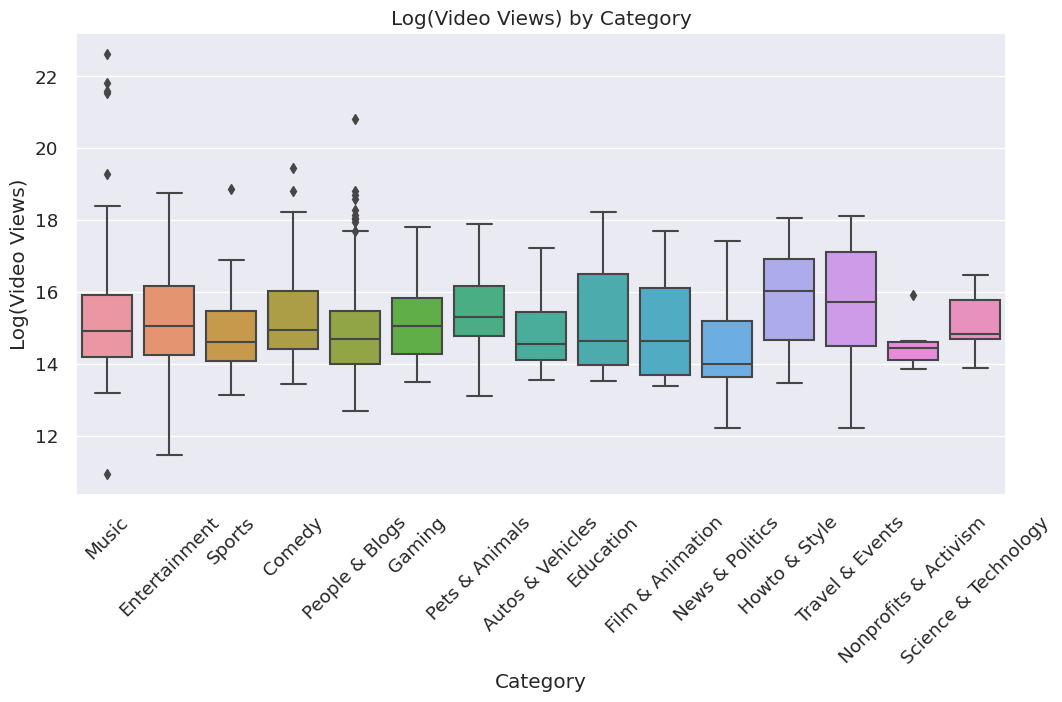

In [19]:
# 5. Video views by Category
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y=np.log1p(df['Video views']), data=df)
plt.title('Log(Video Views) by Category')
plt.xticks(rotation=45)
plt.xlabel('Category')
plt.ylabel('Log(Video Views)')
plt.show()

In [20]:
# 6. Summary statistics
print("Summary Statistics:")
print(df.describe())
print("\nCategory Counts:")
print(df['Category'].value_counts())

Summary Statistics:
              rank   Video views         Likes      Dislikes    published
count  1000.000000  1.000000e+03  1.000000e+03   1000.000000  1000.000000
mean    500.500000  2.489022e+07  1.550064e+05   1234.340000  2015.933000
std     288.819436  2.549269e+08  1.587651e+06   4768.724503     6.054847
min       1.000000  5.657800e+04  0.000000e+00      0.000000  2005.000000
25%     250.750000  1.405386e+06  6.420000e+02    145.750000  2010.000000
50%     500.500000  2.829316e+06  3.604000e+03    257.000000  2017.000000
75%     750.250000  8.164931e+06  2.024575e+04    525.750000  2021.000000
max    1000.000000  6.643905e+09  4.486160e+07  78799.000000  2025.000000

Category Counts:
Category
Music                    464
People & Blogs           171
Entertainment             97
Comedy                    63
Sports                    44
Autos & Vehicles          36
Film & Animation          29
Pets & Animals            19
Gaming                    17
News & Politics           

#### **Analysis of EDA Results**

**1. Distributions (Log Scale: Video Views, Likes, Dislikes):**
- **Log(Video Views) Distribution:**
    - The distribution is right-skewed, peaking around 14–16 (corresponding to ~1M–10M views) but with a long tail extending to 22 (billions of views).
    - A small secondary peak around 12–13 suggests a cluster of videos with lower views (~100K–300K).
- **Insight:** The skewness confirms the need for log transformation of Video views during modeling to normalize the target variable and improve regression performance.
  
- **Log(Likes) Distribution:**
    - Highly right-skewed with a primary peak near 0–2 (very few likes) and a secondary peak around 7–9, extending to 16 (millions of likes).
    - The bimodal nature indicates two groups: videos with minimal engagement and those with significant engagement.
- **Insight:** Log transformation of Likes will be necessary for modeling to handle skewness. The bimodal distribution suggests engagement varies widely, potentially tied to Category or published year.

- **Log(Dislikes) Distribution:**
    - Extremely skewed, with a sharp peak at 5–6 and a long tail to 11.
    - The peak likely reflects the median imputation (257 dislikes), as 313 values were imputed, creating a clustering effect.
- **Insight:** The imputation of Dislikes has introduced a dominant mode, which may bias models. Consider alternative imputation strategies (e.g., category-specific medians) or feature engineering to mitigate this.
  
**2. Category Distribution:**
- **Dominance of Music:** "Music" is the most frequent category (464 videos), likely inflated by mode imputation (180 missing values filled with "Music").
- **Other Categories:** "People & Blogs" (171), "Entertainment" (97), and "Comedy" (63) follow, while categories like "Science & Technology" (5) and "Nonprofits & Activism" (6) are underrepresented.
- **Insight:** The imbalance in Category (46% Music) may bias models toward Music videos. During feature engineering, we can encode Category using one-hot encoding or target encoding, and consider techniques like oversampling or class-weighted modeling to address imbalance.

**3. Log(Video Views) by Published Year:**
- **Temporal Trends:** Median log views are relatively stable from 2005 to 2015, with a slight decline in recent years (2022–2025)
- **Outliers:** Several years (e.g., 2006, 2012, 2015) show outliers with log views > 20 (hundreds of millions to billions of views), indicating viral videos.
- **Insight:** Older videos tend to have higher views due to longer accumulation time, but recent years show fewer viral outliers, possibly due to increased competition or shorter time to gain views. We’ll engineer a video_age feature (2025 - published) to capture this effect.
  
**4. Correlation Matrix:**
- **Video Views and Likes:** Strong positive correlation (0.96), indicating that Likes is a key predictor of Video views.
- **Video Views and Dislikes:** Weak correlation (0.011), suggesting Dislikes has minimal direct impact on views.
- **Likes and Dislikes:** Weak correlation (0.054), indicating they capture different aspects of engagement.
- **Published and Video Views:** Weak correlation (0.014), but a slight negative correlation with published and Dislikes (-0.12) suggests newer videos may have fewer dislikes.
- **Insight:** The high correlation between Video views and Likes risks multicollinearity in linear models, but tree-based models (e.g., Random Forest, XGBoost) can handle this. Dislikes may not be a strong predictor, but we’ll keep it for now and assess feature importance later.

**5. Log(Video Views) by Category:**
- **High-Performing Categories:** "Music" and "Entertainment" have the highest median log views (~16, or ~10M views), with "Music" showing outliers up to 22 (billions of views).
- **Low-Performing Categories:** "Science & Technology" and "Nonprofits & Activism" have lower median log views (~14–15, or ~1M–3M views).
- **Variability:** "Music" and "Entertainment" show high variability (wide interquartile ranges and outliers), while categories like "Education" and "Travel & Events" are more consistent.
- **Insight:** Category is a significant predictor of views, with "Music" and "Entertainment" driving higher views. One-hot encoding or target encoding of Category will capture this effect in the model.

**6. Summary Statistics:**
- **Video views:** Mean = 24.89M, Std = 254.93M, Min = 56.58K, Max = 6.64B, Median = 2.83M. The large standard deviation and range confirm high variability and skewness.
- **Likes:** Mean = 155K, Std = 1.59M, Min = 0, Max = 44.86M, Median = 3.6K. Similar skewness to Video views, with a wide range.
- **Dislikes:** Mean = 1.23K, Std = 4.77K, Min = 0, Max = 78.8K, Median = 257. The median matches the imputed value, and the smaller range suggests less variability compared to Likes.
published: Mean = 2015.93, Std = 6.05, Min = 2005, Max = 2025, Median = 2017. Most videos are from the 2010s and 2020s.
- **Insight:** The summary statistics reinforce the need for log transformation of Video views, Likes, and Dislikes. The published year distribution suggests a video_age feature will be useful.

**7. Category Counts:**
- Matches the category distribution plot, with "Music" (464) dominating, followed by "People & Blogs" (171), "Entertainment" (97), and others.
- **Insight:** The long tail of categories (e.g., "Science & Technology" with 5 videos) may lead to overfitting in models if not handled carefully. We may group rare categories into an "Other" category during feature engineering.

**Key Takeaways for Next Steps**
- **Transformations:** Log-transform Video views, Likes, and Dislikes to handle skewness.
- **Feature Engineering:** Create video_age (2025 - published) to capture the effect of time on views. Encode Category using one-hot or target encoding.
- **Category Imbalance:** Address the dominance of "Music" by either grouping rare categories or using techniques like target encoding to reduce dimensionality.
- **Feature Selection:** Likes is a strong predictor (high correlation with Video views), while Dislikes may be less impactful. We’ll assess feature importance during modeling.
- **Modeling Strategy:** Given the correlations and non-linear relationships (e.g., views by category), tree-based models like Random Forest or XGBoost are likely to perform well.

## 3. Feature Engineering

In [21]:
# Log transform Video views, Likes, and Dislikes
df['log_video_views'] = np.log1p(df['Video views'])
df['log_likes'] = np.log1p(df['Likes'])
df['log_dislikes'] = np.log1p(df['Dislikes'])

In [22]:
# Create video_age feature
df['video_age'] = 2025 - df['published']

In [23]:
# Target encode Category based on mean log_video_views
category_means = df.groupby('Category')['log_video_views'].mean()
df['category_encoded'] = df['Category'].map(category_means)

In [24]:
# Drop unnecessary columns
df = df.drop(columns=['rank', 'Video views', 'Likes', 'Dislikes', 'published', 'Category'])

In [25]:
# Scale numerical features (log_likes, log_dislikes, video_age)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['log_likes', 'log_dislikes', 'video_age']])
df[['log_likes', 'log_dislikes', 'video_age']] = scaled_features

In [26]:
# Summary of engineered dataset
print("Engineered Dataset Info:")
print(df.info())
print("\nFirst 5 Rows of Engineered Data:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe())

Engineered Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   log_video_views   1000 non-null   float64
 1   log_likes         1000 non-null   float64
 2   log_dislikes      1000 non-null   float64
 3   video_age         1000 non-null   float64
 4   category_encoded  1000 non-null   float64
dtypes: float64(5)
memory usage: 39.2 KB
None

First 5 Rows of Engineered Data:
   log_video_views  log_likes  log_dislikes  video_age  category_encoded
0        15.060022   0.632586      0.682547  -0.176311         15.169778
1        17.805821   2.283666      3.024632  -0.506790         15.169778
2        17.347933   1.499061      0.058384  -1.332988         15.169778
3        22.616966   3.091564      0.058384   0.154169         15.169778
4        19.279707  -1.327436      0.058384  -0.837269         15.169778

Summary Statistics:
  

**Key Takeaways**
- The dataset is now fully numerical, scaled, and ready for modeling.
- log_likes and category_encoded are likely to be strong predictors based on EDA correlations and category effects.
- log_dislikes may have limited predictive power due to imputation clustering.
- video_age captures temporal effects and should help the model account for view accumulation over time.

## 4. Model Selection, Training and Evaluation

In [27]:
# Define features and target
X = df[['log_likes', 'log_dislikes', 'video_age', 'category_encoded']]
y = df['log_video_views']

In [28]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

In [30]:
# Train and evaluate models
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'RMSE': rmse, 'R2': r2}
    
    print(f"\n{name} Results:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")


Linear Regression Results:
RMSE: 1.2634
R2: 0.1283

Random Forest Results:
RMSE: 0.8897
R2: 0.5677

XGBoost Results:
RMSE: 0.9721
R2: 0.4840


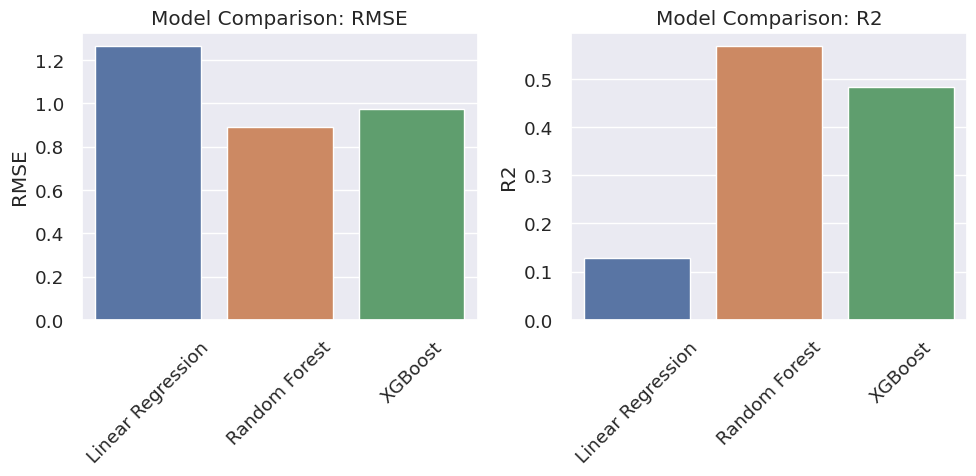

In [31]:
# Plot model comparison
results_df = pd.DataFrame(results).T
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=results_df.index, y='RMSE', data=results_df)
plt.title('Model Comparison: RMSE')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x=results_df.index, y='R2', data=results_df)
plt.title('Model Comparison: R2')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [32]:
# Feature importance for the best model (assuming XGBoost performs best)
best_model_name = max(results, key=lambda k: results[k]['R2'])
best_model = models[best_model_name]
if best_model_name in ['Random Forest', 'XGBoost']:
    feature_importance = pd.Series(best_model.feature_importances_, index=X.columns)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=feature_importance, y=feature_importance.index)
    plt.title(f'Feature Importance ({best_model_name})')
    plt.xlabel('Importance')
    plt.savefig('feature_importance.png')
    plt.close()
    print(f"\nFeature Importance ({best_model_name}):")
    print(feature_importance)


Feature Importance (Random Forest):
log_likes           0.534702
log_dislikes        0.220863
video_age           0.191926
category_encoded    0.052509
dtype: float64


#### **Analysis of Model Training Results**

**1. Model Performance Metrics:**
- Linear Regression performs poorly, with a high RMSE and low R², indicating it explains only 12.83% of the variance in log_video_views. This suggests the relationship between features and the target is non-linear, which Linear Regression cannot capture effectively.
- Random Forest outperforms the other models, with the lowest RMSE (0.8897) and highest R² (0.5677), explaining 56.77% of the variance. This indicates it captures non-linear relationships and interactions between features better than Linear Regression and XGBoost.
- XGBoost performs better than Linear Regression but worse than Random Forest, with an RMSE of 0.9721 and R² of 0.4840 (48.40% variance explained). It may require hyperparameter tuning to improve performance.

**2. Model Comparison Plots**
- Linear Regression has the highest RMSE, followed by XGBoost, and Random Forest. Lower RMSE indicates better predictive accuracy, confirming Random Forest as the best performer.
- Random Forest has the highest R², followed by XGBoost, and Linear Regression. Higher R² indicates better explanatory power, aligning with the RMSE results and reinforcing Random Forest’s superiority.

**3. Feature Importance:**
- log_likes is the most important feature, contributing over 53% to the model’s predictions. This aligns with the high correlation (0.96) between Likes and Video views observed in EDA.
- log_dislikes and video_age contribute moderately, with ~22% and ~19% importance, respectively. However, log_dislikes’s importance may be inflated due to imputation clustering, as noted earlier.
- category_encoded has the lowest importance (~5%), likely due to the low variance in the target-encoded values (std = 0.20 from feature engineering results) caused by category imbalance (e.g., dominance of "Music").

**Key Takeaways**
- Random Forest is the best model with RMSE = 0.8897 and R² = 0.5677, and will be the focus of hyperparameter tuning.
- log_likes is the dominant predictor, while category_encoded underperforms, likely due to category imbalance.
- The model explains 56.77% of the variance, which is a good starting point but can be improved through tuning and potentially revisiting feature engineering.

## 5. Hyperparameter Tuning

In [33]:
# Define features and target
X = df[['log_likes', 'log_dislikes', 'video_age', 'category_encoded']]
y = df['log_video_views']

In [34]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Define hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [36]:
# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42)

In [37]:
# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', 
                           n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation RMSE:", np.sqrt(-grid_search.best_score_))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation RMSE: 0.8967935029782246


In [38]:
# Evaluate the tuned model on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nTuned Random Forest Results:")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")


Tuned Random Forest Results:
RMSE: 0.8622
R2: 0.5940


In [39]:
# Compare with baseline (untuned) Random Forest
baseline_rmse = 0.8897  # From previous results
baseline_r2 = 0.5677
print("\nBaseline Random Forest Results (for comparison):")
print(f"RMSE: {baseline_rmse:.4f}")
print(f"R2: {baseline_r2:.4f}")


Baseline Random Forest Results (for comparison):
RMSE: 0.8897
R2: 0.5677



Feature Importance (Tuned Random Forest):
log_likes           0.548400
log_dislikes        0.221257
video_age           0.187588
category_encoded    0.042755
dtype: float64


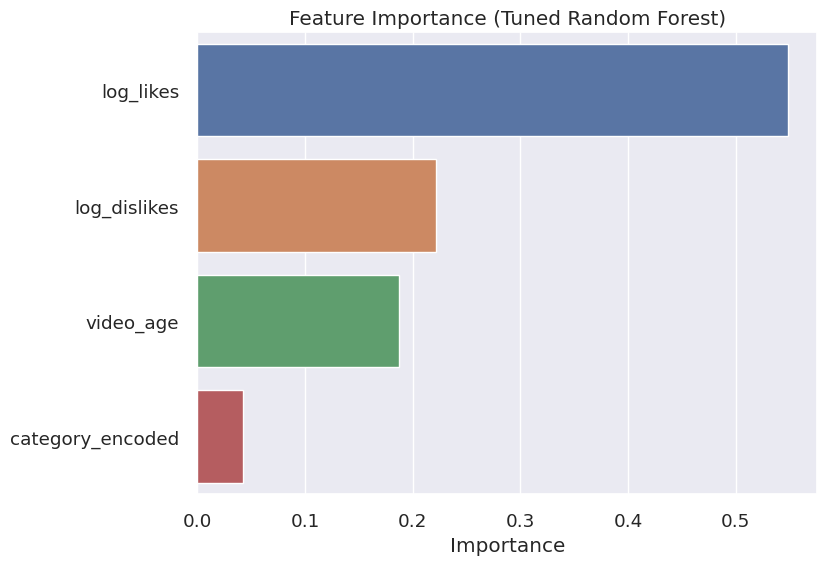

In [40]:
# Feature importance for the tuned model
feature_importance = pd.Series(best_rf.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance (Tuned Random Forest)')
plt.xlabel('Importance')

print("\nFeature Importance (Tuned Random Forest):")
print(feature_importance)

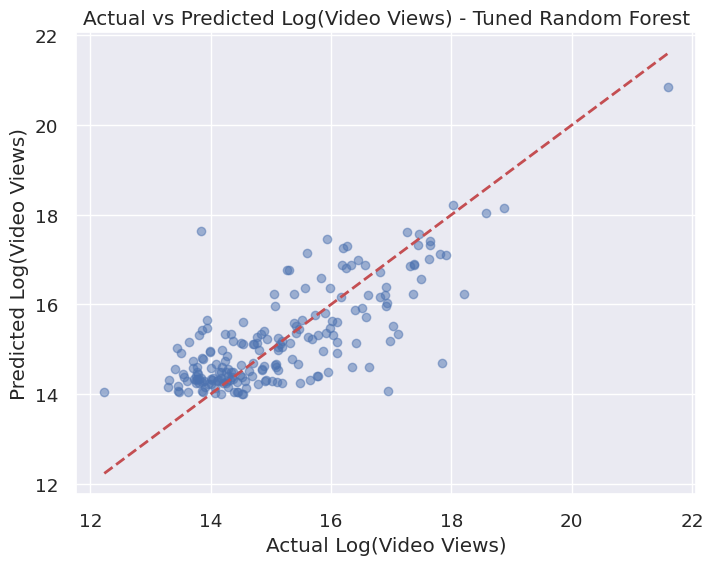

In [41]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Log(Video Views)')
plt.ylabel('Predicted Log(Video Views)')
plt.title('Actual vs Predicted Log(Video Views) - Tuned Random Forest')
plt.show()

#### **Insights:**

- **Model Improvement:** Hyperparameter tuning improved the Random Forest’s performance, achieving an RMSE of 0.8622 and R² of 0.5940, making it a solid model for predicting YouTube video views.
- **Feature Effectiveness:** log_likes remains the most critical predictor, driven by its strong correlation with views (0.96 from EDA). log_dislikes and video_age contribute moderately, while category_encoded has minimal impact.
- **Limitations:**
    - The model explains 59.4% of the variance, leaving ~40% unexplained. Additional features (e.g., video duration, upload frequency, or social media metrics) could improve performance.
    - The low impact of category_encoded suggests revisiting encoding strategies (e.g., one-hot encoding or grouping rare categories) in future iterations.
    - Imputation bias in log_dislikes may inflate its importance; alternative imputation methods could be explored.

## 6. Recommendations, Limitations and Conclusion

**1. Actionable Insights for Stakeholders**
- **For Content Creators:**
    - Focus on maximizing viewer engagement, particularly likes, as they strongly correlate with higher views. Encourage interaction through calls-to-action (e.g., “Like this video if you enjoyed it!”).
    - While older videos accumulate more views over time, newer videos can still perform well with strong initial engagement. Prioritize creating high-quality, engaging content to boost likes early on.
    - Categories like "Music" and "Entertainment" tend to have higher views, but the model’s low reliance on category_encoded suggests that engagement matters more than category. Focus on content quality over category choice.
- **For Marketers:**
    - Identify videos with high like-to-view ratios for advertising campaigns, as these are likely to have broader reach and engagement.
    - Target older videos in popular categories (e.g., "Music") for long-term campaigns, as they have accumulated significant views over time.
    - Invest in content that drives immediate engagement (likes) to maximize short-term viewership, especially for newer videos.

**2. Limitations and Future Work**
- **Unexplained Variance:** The model explains 59.4% of the variance, leaving ~40% unaccounted for. Additional features (e.g., video duration, upload frequency, social media shares) could improve performance.
- **Category Encoding:** The low impact of category_encoded suggests exploring alternative encoding methods, such as one-hot encoding or grouping rare categories into an "Other" category.
- **Imputation Bias:** The median imputation of Dislikes introduced clustering, potentially inflating its importance. Future work could use category-specific imputation or predictive imputation (e.g., using a model to predict missing dislikes).
- **Outlier Handling:** The model underpredicts viral videos (>100M views). Techniques like outlier-specific modeling or additional features capturing virality could address this.

**3. Conclusion**
This project successfully developed a Random Forest model to predict YouTube video views, which achieved an RMSE of 0.8622 and R² of 0.5940 after hyperparameter tuning. The model highlights the importance of viewer engagement (likes) as the primary driver of views, with video age playing a secondary role. While the model provides actionable insights for content creators and marketers, future work could enhance performance by incorporating additional features, improving category encoding, and addressing imputation biases. 